<a href="https://colab.research.google.com/github/mingshey/python_wave/blob/main/Wave2d_refraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.animation as anim
from matplotlib.animation import PillowWriter

In [ ]:
import scipy.ndimage as scn

In [ ]:
"""
컨벌루션을 위한 커널
"""
kern = scn.generate_binary_structure(2, 1).astype(float)
kern[1,1] = -4

In [ ]:
def fdmstep(past, curr, medsq, rows, cols, tval):
  """
  유한차분법(Finite Differnce Method)에 의해 2차원 파동방정식을 적용하여
  2차원 파동의 진행을 1 time step 씩 진행한다.
  필요한 경우 강제 진동 식을 마지막에 추가한다.
  past: 이전 시간의 파동 상태
  curr: 현재 시간의 파동 상태
  medsq: 매질 속도의 제곱항
  rows, cols: 격자 수
  tval: 현재 시간 값
  (주변 셀과의 상호작용에 의한 항은 컨벌루션(합성곱)을 이용하여 처리한다.)
  """
  global kern, dt, omega, barrier
  fut = 2 * curr - past + scn.convolve(medsq * curr, kern)

  """
  강제 진동: 평면파 파원
  """
  amp = 10.0 # amplitude
  fut[:,0:1] = amp*np.sin(24000.0*tval)

  tval = tval + dt

  return ([curr, fut, tval])

In [ ]:
simname = 'Wave2D-refr'

In [ ]:
"""
가로 세로 격자 수 설정:
"""
rs = 128
cs = 128

speed1 = 331 # 파동의 속력: [m/s]
speed2 = 0.75 * speed1
dt = 1.0e-6  # 시뮬레이션 시간 간격 [s])
dx = 0.01      # 격자 간격 [m])
cspeed = dx/dt # 격자 간격과 시간 간격에 의한 특성 속력 (cf. Courant condition)

#파동이 없는 평형 상태로 배경 설정
pm = np.zeros((rs, cs))
cm = np.zeros((rs, cs))

#점 펄스 파원:
# pm[rs//2-2:rs//2+2, 0:2] = 100.0
# cm[rs//2-2:rs//2+2, 0:2] = 100.0

# 매질:

def borderj(i):
  """
  속도가 다른 매질의 경계선을 정의한다.
  주어진 행번호 i 에 대한 경계선의 열번호 j값을 계산하여 반환한다.
  (0,0)                 (0,cs-1)
  +---------------------+
  |             /       |
  |            /        |
  |           /         |
  | False    /   True   |
  |         /           |
  |        /            |
  |       /             |
  +---------------------+
  (rs-1,0)              (rs-1, cs-1)
  """
  mid = rs//2
  return mid + (mid - i)//2

mm = np.ones((rs, cs)) * speed1     # medium
mi = np.indices(mm.shape)
med2 = mi[1] > borderj(mi[0])  # 경계선 오른쪽 영역

mm[med2] = speed2                  # 경계선 오른쪽 영역의 파동 속력을 r2로 지정
mm_min, mm_max, foo, bar = scn.extrema(mm)
mm_mid = (mm_min + mm_max) / 2

# 매질 속도 성질의 제곱항:
msq = (mm / cspeed)**2

# 시간 초기화
t = 0.0

In [ ]:
mm_max

np.float64(331.0)

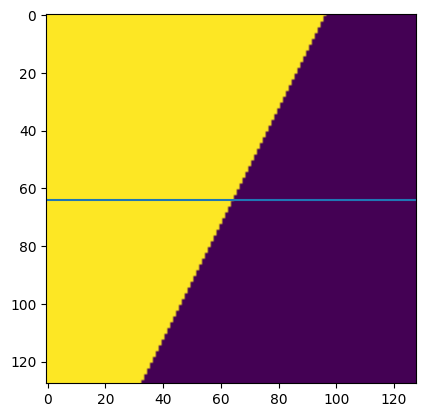

In [ ]:
"""
매질의 성질(파동의 속력)을 나타내는 배열
"""
plt.imshow(mm)
plt.axhline(rs//2)

(0.0, 662.0)

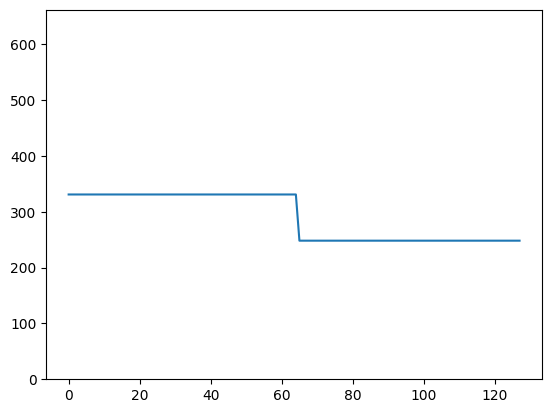

In [ ]:
"""
중심을 지나는 가로선을 따라 매질의 성질(파동의 속력)을 나타내는 그래프
"""
plt.plot(mm[rs//2])
plt.ylim([0,mm_max*2])

In [ ]:
# 시뮬레이션을 진행하며 nn개 시간 간격마다 장면 이미지를 저장한다.
N = 5000 # 총 시뮬레이션 스텝 수
advance = 10  # 이미지 저장 간격
n = N//advance

maps = np.empty((0, rs, cs))
ts = np.array([])

for k in range(n):
  for i in range(advance):
    pm, cm, t = fdmstep(pm, cm, msq, rs, cs, t)
  maps = np.append(maps, [cm], axis=0)
  ts = np.append(ts,[t])

In [ ]:
def frame(k):
  plt.subplot(121)
  ax[0].clear()
  ax[0].set_xlabel("x (cm)")
  ax[0].set_ylabel("y (cm)")
  ax[0].set_title(f"time = {t:.3e} (s)")
  ax[0].imshow(maps[k], vmin=-10.0, vmax=10.0)
  ax[0].axhline(row_sample, color='red', alpha=0.3)
  ax[0].contour(mm, [mm_mid], colors="white")

  plt.subplot(122)
  ax[1].clear()
  ax[1].set_ylim([-15,15])
  ax[1].grid()
  ax[1].set_xlabel("x (cm)")
  ax[1].set_ylabel("wave displacement")
  ax[1].set_title("center row")
  ax[1].plot(maps[k, row_sample], color='red', label="Sample(red)")
  ax[1].legend()

  if k==0:
    ax2 = ax[1].twinx()
    ax2.set_ylabel('wave speed [m/s]')
    ax2.set_ylim([0,500])
    ax2.plot(mm[row_sample], color='gray', label='wave speed(Sample1)')
    ax2.legend(loc='lower right')


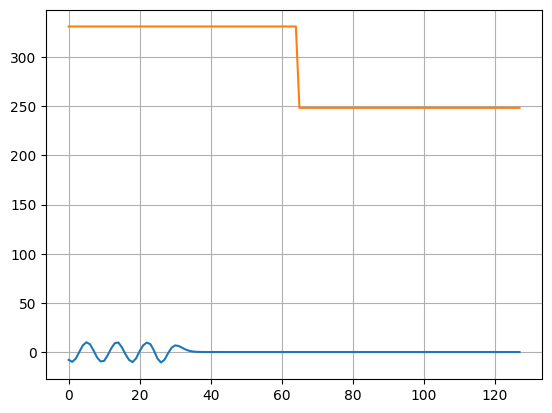

In [ ]:
row_sample = rs//2
#plt.ylim([0, 400])
plt.grid()
plt.plot(maps[100, rs//2])
plt.plot(mm[row_sample])

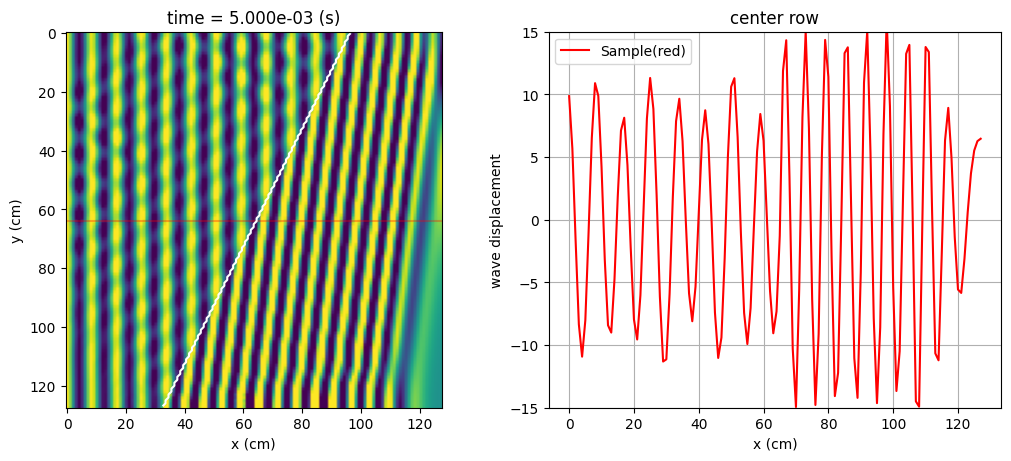

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,4.5), constrained_layout=True)
borderline = ax[0].contour(scn.gaussian_filter(mm,1,0), [(speed1 + speed2)/2], colors="white")
plt.cla()
row_sample = rs//2
frame(450)


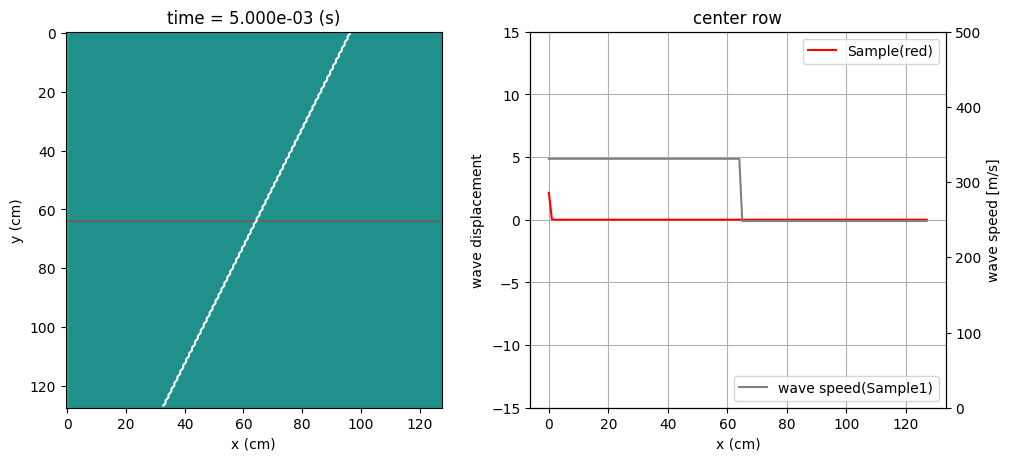

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,4.5), constrained_layout=True)
plt.cla()
ani = anim.FuncAnimation(fig, frame, frames=n)

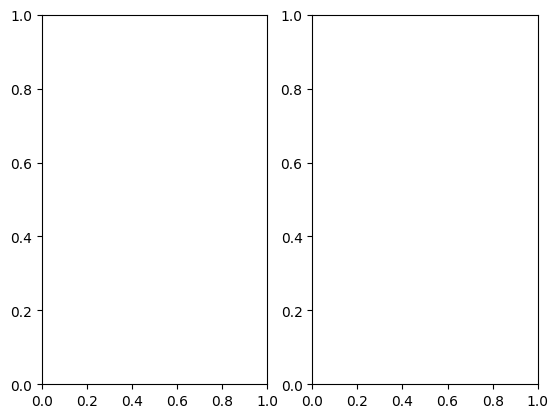

In [ ]:
ani.save(simname + '.gif', writer = 'pillow', fps = 20)

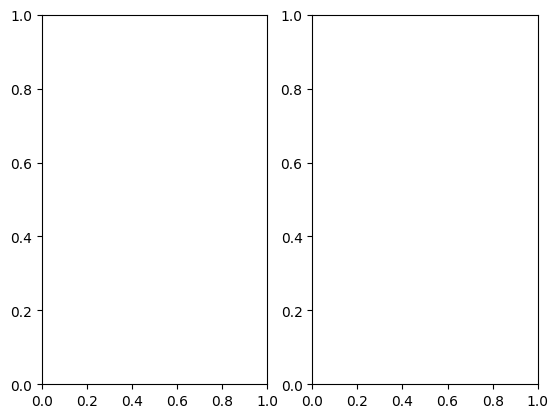

In [ ]:
ani.save(simname + '.avi', dpi = 150, fps = 20)